## Project: Image Captioning
##### Author: Ankit Kumar Prem
---

In this notebook, we will use our trained model to generate captions for images in the test dataset.


### Getting Data Loader for Test Dataset


In [ ]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


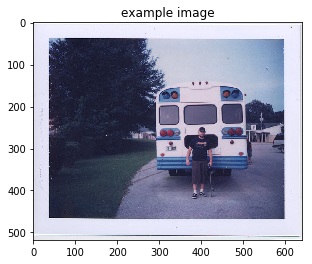

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Loading the Trained Models



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = "encoder-3.pkl" 
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

## Finish the Sampler



In [ ]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

example output: [0, 3, 174, 900, 54, 3, 33, 21, 3, 36, 77, 32, 297, 18, 1, 1, 1, 18, 1, 1]


## Step 4: Clean up the Captions

The `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` ) as input and return the corresponding predicted sentence (as a single Python string). 

In [ ]:
def clean_sentence(output):
    sentence = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + ' ' + word
    
    return sentence.strip()

In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a bus driving down a street with a car in the background.


## Generate Predictions!

We write a function (`get_prediction`) that can be used to loop over images in the test dataset and print our model's predicted caption.

In [ ]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

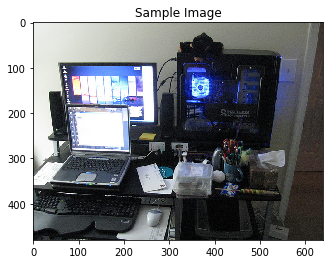

a desk with a laptop , a monitor , and a keyboard.


In [ ]:
get_prediction()

### We can see that the model performed well!


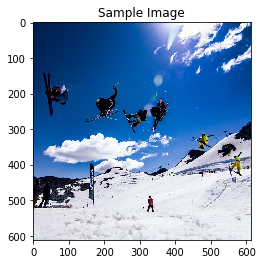

a snowboarder is doing a trick in the air.


In [ ]:
get_prediction()

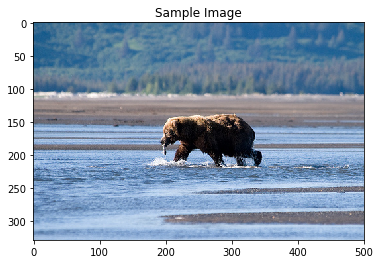

a bear that is standing in the water.


In [ ]:
get_prediction()

### The model could have performed better ...


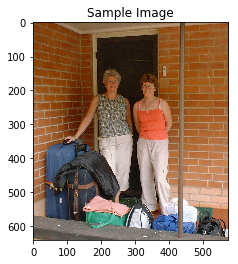

a man and a woman are sitting on a bench.


In [ ]:
get_prediction()

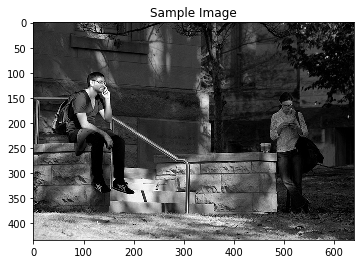

a man is riding a skateboard on a ramp.


In [ ]:
get_prediction()

Not so good!!